In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

import neuro_morpho_toolbox as nmt
# ns=nmt.neuron_set('/Users/pengxie/Documents/Research/fullMorph_classification/data/registered_swc/Janelia_test/swc/Whole/')
ns=nmt.neuron_set('/home/penglab/Documents/Janelia_1000')



/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.83
Loading CCF brain structure data...
Loading time: 0.00
Loading...
100 loaded: 2.8s
Invalid number of soma found: 0
QC failed: AA0114.swc
Invalid number of soma found: 0
QC failed: AA0115.swc
200 loaded: 2.4s
300 loaded: 2.8s
400 loaded: 2.8s
Invalid number of soma found: 0
QC failed: AA0472.swc
500 loaded: 2.7s
Invalid number of soma found: 0
QC failed: AA0576.swc
Invalid number of soma found: 0
QC failed: AA0585.swc
Invalid number of soma found: 0
QC failed: AA0589.swc
600 loaded: 2.5s
Invalid number of soma found: 0
QC failed: AA0639.swc
Invalid number of soma found: 0
QC failed: AA0670.swc
Invalid number of soma found: 0
QC failed: AA0672.swc
700 loaded: 2.4s
Invalid number of soma found: 0
QC failed: AA0754.swc
Invalid number of soma found: 0
QC failed: AA0763.swc
800 loaded: 3.0s
900 loaded: 2.2s
QC failed: AA0952.swc
QC failed: AA0964.swc
QC failed: AA0968.swc
QC

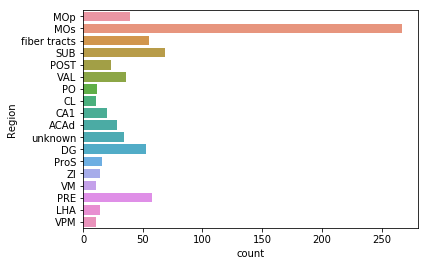

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)


## Initialization for each cluster 

In [4]:
colname = ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient','parameter']
#method=['SNN_community','Kmeans'
#%% Store all the result
result_COMP = pd.DataFrame(columns = colname)

## For hierarchy

#%% Store the result of Hierarchy
result_hier = pd.DataFrame(columns = colname)
L_method_list=['single', 'complete','average','weighted','centroid','median','ward']
L_metric_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
               'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
               'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
               'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
#linkage using 'yule' and 'jensenshannon' may result in a condensed distance matrix must contain only finite values.

criterionH_list=['inconsistent','distance','maxclust','monocrit','maxclust_monocrit']

hier_dict={'L_method':'single', 'L_metric':'euclidean','criterionH':'inconsistent', 'depth':2,'R':None,'t':0.9,'optimal_ordering':False}
for L_methodidx in L_method_list:
    hier_dict.update(L_method = L_methodidx)
    for L_metricidx in L_metric_list:
        hier_dict.update(L_metric = L_metricidx )
        for criterionidx in criterionH_list:
            hier_dict.update(criterionH = criterionidx )   
            for depth_iter in range(2,15):
                hier_dict.update(depth = depth_iter ) 
                print(hier_dict)
                _ = ns. get_clusters(method='Hierarchy',karg_dict=hier_dict)
                h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
                if len(typeR)<2:
                    SS = 'below'
                elif len(typeR)>=ns.UMAP.shape[0]:
                    SS = 'above'
                else:
                    SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
                tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(hier_dict)]).T.copy()
                tempDF.columns=colname
                result_hier = result_hier.append(tempDF)    
idx_hier = ['Hier'+str(x) for x in range(result_hier.shape[0])]    
result_hier['idx'] = idx_hier
result_hier.set_index('idx',inplace=True)    

In [6]:
#result_hier.to_excel('/home/penglab/Documents/dataSource/result_hier.xlsx')
result_hier = pd.read_excel('/home/penglab/Documents/dataSource/result_hier.xlsx', index_col=0)

## For KMeans


from sklearn import metrics
colname = ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient','parameter']
#method=['SNN_community','Kmeans'
result_kmeans = pd.DataFrame(columns = colname)

init_list=['k-means++','random']
algorithm_list = ['auto','full','elkan']
precompute_distances_list = ['auto', True, False]
n_init_list=['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine',
               'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
               'mahalanobis', 'matching','minkowski','rogerstanimoto', 'russellrao',
               'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
#linkage using 'yule' and 'jensenshannon' may result in a condensed distance matrix must contain only finite values.

criterionH_list='inconsistent','distance','maxclust','monocrit','maxclust_monocrit'

kmeans_dict={'n_clusters':20, 'init':'k-means++', 'n_init':10, 'max_iter':300, 'tol':0.0001,'precompute_distances':'auto', 'verbose':0, 'random_state':None,'copy_x': True,'n_jobs':None, 'algorithm':'auto'}

for init_idx in init_list:
    kmeans_dict.update(init = init_idx)
    for algorithm_idx in algorithm_list:
        kmeans_dict.update(algorithm = algorithm_idx )
        for precompute_distances_idx in precompute_distances_list:
            kmeans_dict.update(precompute_distances = precompute_distances_idx )
            for n_clustersidx in range(3,25):
                kmeans_dict.update(n_clusters = n_clustersidx)     
                #Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
                for n_initidx in range(7,25):
                    kmeans_dict.update(n_init = n_initidx) 
                    print(kmeans_dict)
                    _ = ns. get_clusters(method='Kmeans',karg_dict=kmeans_dict)
                    h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
                    if len(typeR)<2:
                        SS = 'below'
                    elif len(typeR)>=ns.UMAP.shape[0]:
                        SS = 'above'
                    else:
                        SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
                    
                    tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(kmeans_dict)]).T.copy()
                    tempDF.columns=colname
                    result_kmeans = result_kmeans.append(tempDF)         
idx_kmeans = ['KMeans'+str(x) for x in range(result_kmeans.shape[0])]    
result_kmeans['idx'] = idx_kmeans
result_kmeans.set_index('idx',inplace=True)       

In [7]:
#result_kmeans.to_excel('/home/penglab/Documents/dataSource/result_kmeans.xlsx')
result_kmeans = pd.read_excel('/home/penglab/Documents/dataSource/result_kmeans.xlsx', index_col=0)

## for DBSCAN


result_dbscan = pd.DataFrame(columns = colname)
algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']
dbscan_dict={'eps':20, 'min_samples':5, 'metric':'euclidean','metric_params':None, 'algorithm':'auto', 'leaf_size':30, 'p':None,'n_jobs':None}
for algorithm_idx in algorithm_list:
    dbscan_dict.update(algorithm = algorithm_idx )
    for epsidx in np.arange(0,1,0.005)[1:]:
        dbscan_dict.update(eps = epsidx)
        #print(result_dbscan )
        _ = ns. get_clusters(method='DBSCAN',karg_dict=dbscan_dict)
        h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
        if len(typeR)<2:
            SS = 'below'
        elif len(typeR)>=ns.UMAP.shape[0]:
            SS = 'above'
        else:
            SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
        tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(dbscan_dict)]).T.copy()
        tempDF.columns=colname
        result_dbscan = result_dbscan.append(tempDF)        
idx_dbscan = ['DBSCAN'+str(x) for x in range(result_dbscan.shape[0])]    
result_dbscan['idx'] = idx_dbscan
result_dbscan.set_index('idx',inplace=True)       

In [8]:
#result_dbscan.to_excel('/home/penglab/Documents/dataSource/result_dbscan.xlsx')
result_dbscan = pd.read_excel('/home/penglab/Documents/dataSource/result_dbscan.xlsx', index_col=0)

## for HDBSCAN


result_hdbscan = pd.DataFrame(columns = colname)
from sklearn.neighbors.ball_tree import BallTree
metric_list = ['euclidean', 'manhattan', 'cityblock', 'l1', 'chebyshev','l2', 'minkowski']
#, 'p', 'seuclidean', 
              # 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 
             #  'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener','sokalsneath', 'haversine', 'pyfunc']
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan','braycurtis',
              # 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 
             #  'kulsinski', 'mahalanobis', 'matching', 'minkowski','rogerstanimoto', 
              # 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
#check use of 'boruvka_balltree' for algorithm later
algorithm_list = ['best', 'generic','prims_kdtree', 'boruvka_kdtree']#, 
cluster_selection_method_list = ['leaf','eom']
hdbscan_dict={'min_cluster_size':5, 'metric':'euclidean','alpha':1.0, 'min_samples':1,
              'p':2,'algorithm':'best', 'leaf_size':40, 'approx_min_span_tree':True,
              'gen_min_span_tree':False,'core_dist_n_jobs':4,'cluster_selection_method':'eom',
              'allow_single_cluster': False,'prediction_data':False,
              'match_reference_implementation':False}

for algorithm_idx in algorithm_list:
    hdbscan_dict.update(algorithm = algorithm_idx)
    for metric_idx in metric_list:
        hdbscan_dict.update(metric = metric_idx)
        for cluster_selection_method_idx in cluster_selection_method_list:
            hdbscan_dict.update(cluster_selection_method = cluster_selection_method_idx )
            for alpha_idx in np.arange(0.8,1.5,0.1):
                hdbscan_dict.update(alpha = alpha_idx)
                for min_samples_iter in range(1,10):
                    hdbscan_dict.update(min_samples = min_samples_iter)
            
                    #print(hdbscan_dict)
                    _ = ns. get_clusters(method='HDBSCAN',karg_dict=hdbscan_dict)
                    h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
                    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
                    if len(typeR)<2:
                        SS = 'below'
                    elif len(typeR)>=ns.UMAP.shape[0]:
                        SS = 'above'
                    else:
                        SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
                    print(hdbscan_dict)
                    tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,str(hdbscan_dict)]).T.copy()
                    tempDF.columns = colname
                    result_hdbscan = result_hdbscan.append(tempDF)     
                    
idx_hdbscan = ['HDBSCAN'+str(x) for x in range(result_hdbscan.shape[0])]    
result_hdbscan['idx'] = idx_hdbscan
result_hdbscan.set_index('idx',inplace=True)       



In [9]:
#result_hdbscan.to_excel('/home/penglab/Documents/dataSource/result_hdbscan.xlsx')
result_hdbscan = pd.read_excel('/home/penglab/Documents/dataSource/result_hdbscan.xlsx', index_col=0)

## Pre-process the data
* result_hier      9100 x 7
* result_kmeans    7128 x 7
* result_dbscan    796  x 7
* result_hdbscan   3528  x 7

## Plot each kind of clustering result separately

* Each line corresponds to one column
* Show the fluctuation of each method using different parameters



In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_col(dflocal,cluster_name,dropF):
    #result_hier_self=result_hier.copy()
    if dropF:
        df = dflocal.iloc[:,:-1].drop_duplicates()
    else:
        df = dflocal.copy()
    df = df[df['Silhouette Coefficient']!='below'].copy()
    df = df[df['Silhouette Coefficient']!='above'].copy()
    col_Homogeneity = df['Homogeneity']
    col_Completeness = df['Completeness']
    col_Vmeasure= df['V-measure']
    col_ARI = df['Adjusted Rand Index']
    col_AMI = df['Adjusted Mutual Information']
    col_SC = df['Silhouette Coefficient']
    
    x_axix=range(1,df.shape[0]+1)

    plt.title('Value fluctuation for '+str(cluster_name)+'with '+str(df.shape[0])+' unique trials')
    plt.plot(x_axix, col_Homogeneity.tolist(), color='green', label='Homogeneity')
    plt.plot(x_axix, col_Completeness.tolist(), color='brown', label='Completeness')
    plt.plot(x_axix, col_Vmeasure.tolist(),  color='skyblue', label='V-measure')
    plt.plot(x_axix, col_ARI.tolist(), color='blue', label='Adjusted Rand Index')
    plt.plot(x_axix, col_AMI.tolist(), color='magenta', label='Adjusted Mutual Information')
    plt.plot(x_axix, col_SC.tolist(), color='pink', label='Silhouette Coefficient')
    plt.legend() # 显示图例
    #a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    #plt.xticks(arange(len(a)),a)
    plt.xlabel('Different Parameter Choices')
    plt.ylabel('metric')
    plt.show()

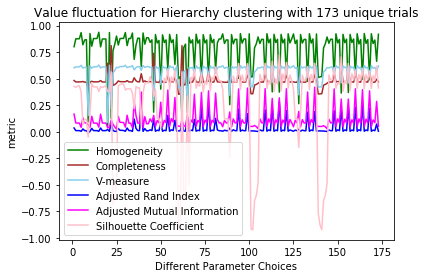

/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



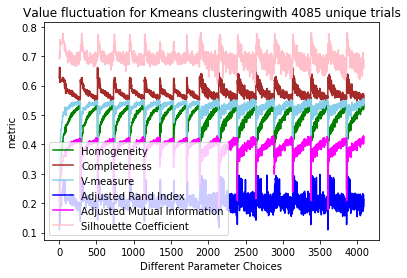

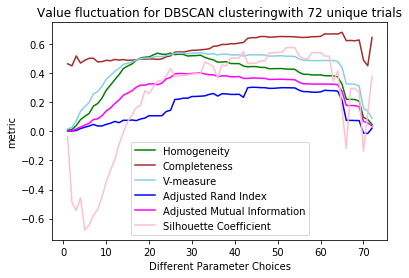

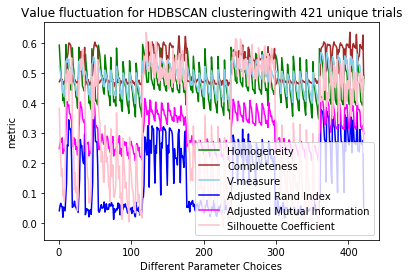

In [13]:

plot_col(result_hier.copy(),'Hierarchy clustering ',1)

plot_col(result_kmeans.copy(),'Kmeans clustering',1)

plot_col(result_dbscan.copy(),'DBSCAN clustering',1)

plot_col(result_hdbscan.copy(),'HDBSCAN clustering',1)

# To compare all the results for different metirc
### Detail
* metric can be 'Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient'
* Delete clustering result leading to cluster less than 2 or # of cluster = # of swc files

### Add SNN

In [14]:
result_snn= pd.DataFrame(columns = colname)
_ = ns. get_clusters(method='SNN_community',
                     karg_dict={'knn':5,
                                'metric':'minkowski',
                                'method':'FastGreedy'})
h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
if len(typeR)<2:
    SS = 'below'
elif len(typeR)>=ns.UMAP.shape[0]:
    SS = 'above'
else:
    SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
tempDF = pd.DataFrame([h, c,V,ARI,AMI,SS,'default']).T.copy()
tempDF.columns=colname
result_snn = result_snn.append(tempDF)

Result of SNN_community


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [15]:
import numpy as np
import ast
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
def compare_bestmetric(strname):
    result_COMP = pd.DataFrame(columns =['method','parameter','num_Cluster'],index=['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'])
    #if strname=='Silhouette Coefficient':
    scresult_hier = result_hier.copy()
    scresult_kmeans = result_kmeans.copy()
    scresult_dbscan = result_dbscan.copy()
    scresult_hdbscan = result_hdbscan.copy()
    scresult_snn = result_snn.copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='below'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='below'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='below'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='below'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='below'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='above'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='above'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='above'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='above'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='above'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Completeness']!=1].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Completeness']!=1].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Completeness']!=1].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Completeness']!=1].copy()
    scresult_snn = scresult_snn[scresult_snn['Completeness']!=1].copy()
    row_hier = scresult_hier[scresult_hier[strname]==scresult_hier[strname].max()].iloc[0,:]
    row_kmeans = scresult_kmeans[scresult_kmeans[strname]==scresult_kmeans[strname].max()].iloc[0,:]
    row_dbscan = scresult_dbscan[scresult_dbscan[strname]==scresult_dbscan[strname].max()].iloc[0,:]
    row_hdbscan = scresult_hdbscan[scresult_hdbscan[strname]==scresult_hdbscan[strname].max()].iloc[0,:]
    row_snn = scresult_snn[scresult_snn[strname]==scresult_snn[strname].max()].iloc[0,:]
    '''
    else:        
        row_hier = result_hier[result_hier[strname]==np.max(result_hier[strname])].iloc[0,:]
        row_kmeans = result_kmeans[result_kmeans[strname]==np.max(result_kmeans[strname])].iloc[0,:]
        row_dbscan = result_dbscan[result_dbscan[strname]==np.max(result_dbscan[strname])].iloc[0,:]
        row_hdbscan = result_hdbscan[result_hdbscan[strname]==np.max(result_hdbscan[strname])].iloc[0,:]
    '''
    x_axix=range(1,len(colname))
    
    
    hier_dict=row_hier['parameter']
    result_COMP.loc['Hierarchy']['parameter'] = (hier_dict)
    _ = ns. get_clusters(method='Hierarchy',karg_dict=ast.literal_eval(hier_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Hierarchy is '+str(hier_dict))
    result_COMP.loc['Hierarchy']['num_Cluster']=len(typeR)
    
    kmeans_dict=row_kmeans['parameter']
    result_COMP.loc['Kmeans']['parameter'] = kmeans_dict
    _ = ns. get_clusters(method='Kmeans',karg_dict=ast.literal_eval(kmeans_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Kmeans is '+str(kmeans_dict))
    result_COMP.loc['Kmeans']['num_Cluster']=len(typeR)
    
    dbscan_dict=row_dbscan['parameter']
    result_COMP.loc['DBSCAN']['parameter'] = dbscan_dict
    _ = ns. get_clusters(method='DBSCAN',karg_dict=ast.literal_eval(dbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using DBSCAN is '+str(dbscan_dict))
    result_COMP.loc['DBSCAN']['num_Cluster']=len(typeR)
    
    hdbscan_dict=row_hdbscan['parameter']
    result_COMP.loc['HDBSCAN']['parameter'] = hdbscan_dict
    _ = ns. get_clusters(method='HDBSCAN',karg_dict=ast.literal_eval(hdbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_COMP.loc['HDBSCAN']['num_Cluster']=len(typeR)
    
    #snn_dict=row_snn['parameter']
    result_COMP.loc['SNN']['parameter'] = str({'knn':5,'metric':'minkowski','method':'FastGreedy'})
    _ = ns. get_clusters(method='SNN_community',karg_dict={'knn':5,'metric':'minkowski','method':'FastGreedy'})
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_COMP.loc['SNN']['num_Cluster']=len(typeR)    
    
    plt.title('Result Analysis w.r.t. highest '+str(strname))
    plt.plot(x_axix, row_hier.tolist()[:-1], color='green', label='Hierarchy clustering')
    plt.plot(x_axix, row_kmeans.tolist()[:-1], color='red', label='KMeans clustering')
    plt.plot(x_axix, row_dbscan.tolist()[:-1],  color='skyblue', label='DBSCAN clustering')
    plt.plot(x_axix, row_hdbscan.tolist()[:-1], color='blue', label='HDBSCAN clustering')
    plt.plot(x_axix, row_snn.tolist()[:-1], color='brown', label='SNN clustering')
    plt.legend() # 显示图例
    a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    plt.xticks(arange(len(a)),a)
    plt.ylabel('metric')
    plt.show()
    result_COMP['method']=result_COMP.index
    #print(result_COMP)
    return result_COMP
    

/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN
Result of SNN_community


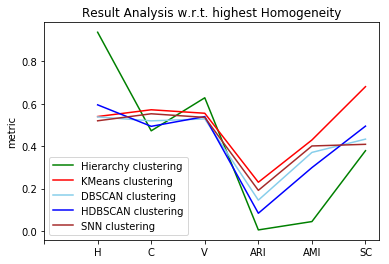

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",695
Kmeans,Kmeans,"{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",24
DBSCAN,DBSCAN,"{'eps': 0.155, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",43
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 1, 'p': 2, 'algorithm': 'best', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False...",64
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28


{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}
{'eps': 0.155, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 1, 'p': 2, 'algorithm': 'best', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of SNN_community


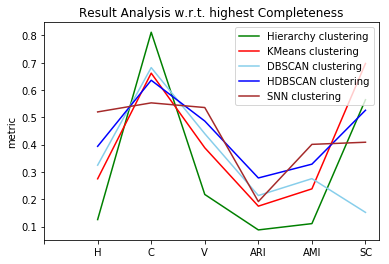

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",2
Kmeans,Kmeans,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
DBSCAN,DBSCAN,"{'eps': 0.49, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",8
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 1.2, 'min_samples': 9, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",20
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28


{'L_method': 'single', 'L_metric': 'correlation', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}
{'eps': 0.49, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 1.2, 'min_samples': 9, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of Hierarchy CLustering
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of DBSCAN
Result of HDBSCAN
Result of SNN_community


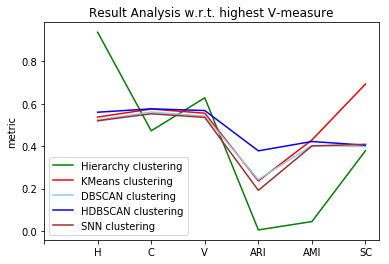

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",695
Kmeans,Kmeans,"{'n_clusters': 23, 'init': 'random', 'n_init': 20, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",23
DBSCAN,DBSCAN,"{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",25
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",53
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28


{'L_method': 'single', 'L_metric': 'chebyshev', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 23, 'init': 'random', 'n_init': 20, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}
{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of SNN_community


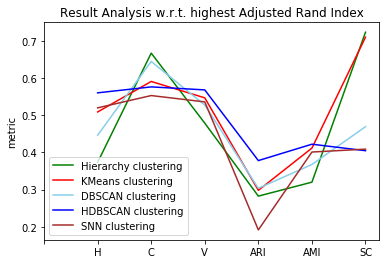

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",7
Kmeans,Kmeans,"{'n_clusters': 19, 'init': 'random', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",19
DBSCAN,DBSCAN,"{'eps': 0.25, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",16
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",53
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28


{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 19, 'init': 'random', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}
{'eps': 0.25, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of Hierarchy CLustering
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of DBSCAN
Result of HDBSCAN
Result of SNN_community


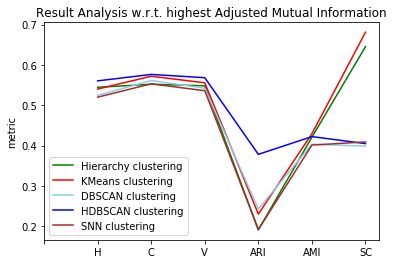

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",33
Kmeans,Kmeans,"{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",24
DBSCAN,DBSCAN,"{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",25
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",53
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28


{'L_method': 'weighted', 'L_metric': 'cityblock', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 24, 'init': 'random', 'n_init': 21, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': False, 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}
{'eps': 0.19, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'chebyshev', 'alpha': 0.8, 'min_samples': 3, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}
Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of SNN_community


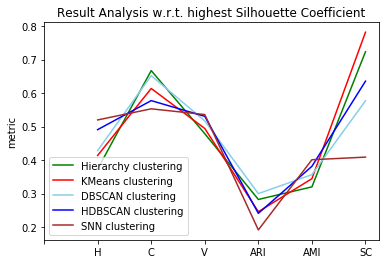

,method,parameter,num_Cluster
Hierarchy,Hierarchy,"{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",7
Kmeans,Kmeans,"{'n_clusters': 10, 'init': 'random', 'n_init': 17, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",10
DBSCAN,DBSCAN,"{'eps': 0.33, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",14
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 6, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",27
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28


{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}
{'n_clusters': 10, 'init': 'random', 'n_init': 17, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}
{'eps': 0.33, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}
{'min_cluster_size': 5, 'metric': 'euclidean', 'alpha': 0.8, 'min_samples': 6, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': False, 'match_reference_implementation': False}
{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}


In [16]:
from IPython.display import display
#'Homogeneity','Completeness','V-measure' did not result in satisfying result
metriclist= ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']

for metric_iter in metriclist:
    bestDF = compare_bestmetric(metric_iter)
    pd.set_option('max_colwidth',300)
    display(bestDF)
    for i in bestDF['parameter']:
        print(i)

In [17]:
colname

['Homogeneity',
 'Completeness',
 'V-measure',
 'Adjusted Rand Index',
 'Adjusted Mutual Information',
 'Silhouette Coefficient',
 'parameter']

# Best average among ARI, AMI and SC

In [22]:
import numpy as np
import ast
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
def compare_bestavg():
    strname='avg'
    result_avg = pd.DataFrame(columns =['method','parameter','num_Cluster','avg'],index=['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'])
    #if strname=='Silhouette Coefficient':
    scresult_hier = result_hier.copy()
    scresult_kmeans = result_kmeans.copy()
    scresult_dbscan = result_dbscan.copy()
    scresult_hdbscan = result_hdbscan.copy()
    scresult_snn = result_snn.copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='below'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='below'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='below'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='below'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='below'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Silhouette Coefficient']!='above'].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Silhouette Coefficient']!='above'].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Silhouette Coefficient']!='above'].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Silhouette Coefficient']!='above'].copy()
    scresult_snn = scresult_snn[scresult_snn['Silhouette Coefficient']!='above'].copy()
    
    scresult_hier = scresult_hier[scresult_hier['Completeness']!=1].copy()
    scresult_kmeans = scresult_kmeans[scresult_kmeans['Completeness']!=1].copy()
    scresult_dbscan = scresult_dbscan[scresult_dbscan['Completeness']!=1].copy()
    scresult_hdbscan = scresult_hdbscan[scresult_hdbscan['Completeness']!=1].copy()
    scresult_snn = scresult_snn[scresult_snn['Completeness']!=1].copy()
 
    scresult_hier['avg']=scresult_hier[['Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_kmeans['avg']=scresult_kmeans[['Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_dbscan['avg']=scresult_dbscan[['Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_hdbscan['avg']=scresult_hdbscan[['Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    scresult_snn['avg']=scresult_snn[['V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient']].sum(axis = 1)/4
    
    row_hier = scresult_hier[scresult_hier[strname]==scresult_hier[strname].max()].iloc[0,:]
    row_kmeans = scresult_kmeans[scresult_kmeans[strname]==scresult_kmeans[strname].max()].iloc[0,:]
    row_dbscan = scresult_dbscan[scresult_dbscan[strname]==scresult_dbscan[strname].max()].iloc[0,:]
    row_hdbscan = scresult_hdbscan[scresult_hdbscan[strname]==scresult_hdbscan[strname].max()].iloc[0,:]
    row_snn = scresult_snn[scresult_snn[strname]==scresult_snn[strname].max()].iloc[0,:]

    x_axix=range(1,len(colname))
    
    
    hier_dict=row_hier['parameter']
    result_avg.loc['Hierarchy']['parameter'] = (hier_dict)
    result_avg.loc['Hierarchy']['avg'] = row_hier['avg']
    _ = ns. get_clusters(method='Hierarchy',karg_dict=ast.literal_eval(hier_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Hierarchy is '+str(hier_dict))
    result_avg.loc['Hierarchy']['num_Cluster']=len(typeR)
    
    kmeans_dict=row_kmeans['parameter']
    result_avg.loc['Kmeans']['parameter'] = kmeans_dict
    result_avg.loc['Kmeans']['avg'] = row_kmeans['avg']
    _ = ns. get_clusters(method='Kmeans',karg_dict=ast.literal_eval(kmeans_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using Kmeans is '+str(kmeans_dict))
    result_avg.loc['Kmeans']['num_Cluster']=len(typeR)
    
    dbscan_dict=row_dbscan['parameter']
    result_avg.loc['DBSCAN']['parameter'] = dbscan_dict
    result_avg.loc['DBSCAN']['avg'] = row_dbscan['avg']
    _ = ns. get_clusters(method='DBSCAN',karg_dict=ast.literal_eval(dbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using DBSCAN is '+str(dbscan_dict))
    result_avg.loc['DBSCAN']['num_Cluster']=len(typeR)
    
    hdbscan_dict=row_hdbscan['parameter']
    result_avg.loc['HDBSCAN']['parameter'] = hdbscan_dict
    result_avg.loc['HDBSCAN']['avg'] = row_hdbscan['avg']
    _ = ns. get_clusters(method='HDBSCAN',karg_dict=ast.literal_eval(hdbscan_dict))
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_avg.loc['HDBSCAN']['num_Cluster']=len(typeR)
    
    #snn_dict=row_snn['parameter']
    result_avg.loc['SNN']['parameter'] = {'knn':5,'metric':'minkowski','method':'FastGreedy'}
    result_avg.loc['SNN']['avg'] = row_snn['avg']
    _ = ns. get_clusters(method='SNN_community',karg_dict={'knn':5,'metric':'minkowski','method':'FastGreedy'})
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print('The parameter resulting in best '+str(strname)+' using HDBSCAN is '+str(hdbscan_dict))
    result_avg.loc['SNN']['num_Cluster']=len(typeR)    
    
    plt.title('Result Analysis w.r.t. highest avg value among ARI, AMI and SC')
    plt.plot(x_axix, row_hier.tolist()[:-2], color='green', label='Hierarchy clustering')
    plt.plot(x_axix, row_kmeans.tolist()[:-2], color='red', label='KMeans clustering')
    plt.plot(x_axix, row_dbscan.tolist()[:-2],  color='skyblue', label='DBSCAN clustering')
    plt.plot(x_axix, row_hdbscan.tolist()[:-2], color='blue', label='HDBSCAN clustering')
    plt.plot(x_axix, row_snn.tolist()[:-2], color='brown', label='SNN clustering')
    plt.legend() # 显示图例
    a=['','H', 'C', 'V', 'ARI', 'AMI', 'SC']
    plt.xticks(arange(len(a)),a)
    plt.ylabel('metric')
    plt.show()
    result_avg['method']=result_avg.index
    #print(result_COMP)
    return result_avg
    

/home/penglab/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Result of Hierarchy CLustering
Result of Kmeans
Result of DBSCAN
Result of HDBSCAN
Result of SNN_community


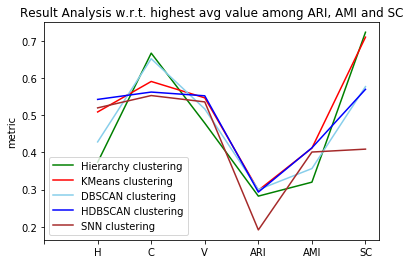

,method,parameter,num_Cluster,avg
Hierarchy,Hierarchy,"{'L_method': 'average', 'L_metric': 'seuclidean', 'criterionH': 'distance', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",7,0.331458
Kmeans,Kmeans,"{'n_clusters': 19, 'init': 'random', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'elkan'}",19,0.354923
DBSCAN,DBSCAN,"{'eps': 0.33, 'min_samples': 5, 'metric': 'euclidean', 'metric_params': None, 'algorithm': 'auto', 'leaf_size': 30, 'p': None, 'n_jobs': None}",14,0.308405
HDBSCAN,HDBSCAN,"{'min_cluster_size': 5, 'metric': 'manhattan', 'alpha': 0.8, 'min_samples': 4, 'p': 2, 'algorithm': 'generic', 'leaf_size': 40, 'approx_min_span_tree': True, 'gen_min_span_tree': False, 'core_dist_n_jobs': 4, 'cluster_selection_method': 'eom', 'allow_single_cluster': False, 'prediction_data': Fa...",37,0.318861
SNN,SNN,"{'knn': 5, 'metric': 'minkowski', 'method': 'FastGreedy'}",28,0.384365


In [26]:
compare_bestavg()

# Look into the detail under different clustering method

* Drop the duplicated rows
* Rerun the clustering method and obtain number of cluster in each method


In [27]:
import ast

def obtainClusterNum(dflocal,cluster_method,dropF):
    #result_hier_self=result_hier.copy()
    colname = ['Homogeneity','Completeness','V-measure','Adjusted Rand Index','Adjusted Mutual Information','Silhouette Coefficient','parameter']
    if dropF:
        dflocal_sub = dflocal.iloc[:,:-1].drop_duplicates()
        indexls = dflocal_sub.index
    else:
        indexls = dflocal.index

    df = pd.DataFrame(columns = colname,index = indexls)
    df['Cluster Num'] = 0
    df['parameter'] = dflocal.loc[indexls,'parameter']
    for iter_idx in df.index:
        _ = ns. get_clusters(method = cluster_method,karg_dict = ast.literal_eval(df.loc[iter_idx]['parameter']))
        h = metrics.homogeneity_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        c = metrics.completeness_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
        if len(typeR)<2:
            SS = 'below'
        elif len(typeR)>=ns.UMAP.shape[0]:
            SS = 'above'
        else:
            SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
        df.loc[iter_idx,'Homogeneity'] = h
        df.loc[iter_idx,'Completeness'] = c
        df.loc[iter_idx,'V-measure'] = V
        df.loc[iter_idx,'Adjusted Rand Index'] = ARI
        df.loc[iter_idx,'Adjusted Mutual Information'] = AMI
        df.loc[iter_idx,'Silhouette Coefficient'] = SS
        typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
        #print(hdbscan_dict)
        df.loc[iter_idx,'Cluster Num'] = len(typeR)
                        
    return df

In [29]:
unique_hier = obtainClusterNum(result_hier.copy(),'Hierarchy',1)
unique_hier.to_excel('/home/penglab/Documents/dataSource/unique_hier.xlsx')
#unique_hier = pd.read_excel('/home/penglab/Documents/dataSource/unique_hier.xlsx', index_col=0)

Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering
Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean
Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean
Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean
Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean
Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean
Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean
Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [30]:
unique_kmeans = obtainClusterNum(result_kmeans.copy(),'Kmeans',1)
unique_kmeans.to_excel('/home/penglab/Documents/dataSource/unique_kmeans.xlsx')
#unique_hier = pd.read_excel('/home/penglab/Documents/dataSource/unique_hier.xlsx', index_col=0)

Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of Kmeans
Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans
Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [31]:
unique_dbscan = obtainClusterNum(result_dbscan.copy(),'DBSCAN',1)
unique_dbscan.to_excel('/home/penglab/Documents/dataSource/unique_dbscan.xlsx')

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN
Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_m

Result of DBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [32]:




unique_hdbscan = obtainClusterNum(result_hdbscan.copy(),'HDBSCAN',1)
unique_hdbscan.to_excel('/home/penglab/Documents/dataSource/unique_hdbscan.xlsx')



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN
Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of HDBSCAN


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



{'whiskers': [<matplotlib.lines.Line2D at 0x7fb6faff8518>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb6fb0172b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6faff8908>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb730191eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7301916a0>],
 'means': []}

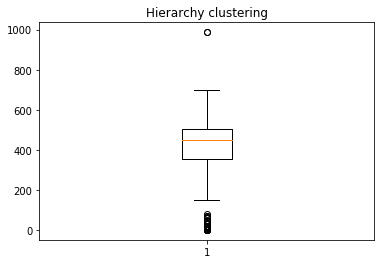

In [33]:
from IPython.display import display
pd.set_option('max_colwidth',300)
#display(unique_hier)
fig1, ax1 = plt.subplots()
ax1.set_title('Hierarchy clustering')
ax1.boxplot(unique_hier['Cluster Num'])

,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information,Silhouette Coefficient,parameter,Cluster Num
idx,,,,,,,,
KMeans0,0.204296,0.624667,0.307895,0.106575,0.175669,0.648796,"{'n_clusters': 3, 'init': 'k-means++', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",3
KMeans1,0.204296,0.624667,0.307895,0.106575,0.175669,0.648796,"{'n_clusters': 3, 'init': 'k-means++', 'n_init': 8, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",3
KMeans6,0.204296,0.624667,0.307895,0.106575,0.175669,0.648796,"{'n_clusters': 3, 'init': 'k-means++', 'n_init': 13, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",3
KMeans18,0.246984,0.614112,0.352286,0.127479,0.209705,0.703348,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 7, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
KMeans19,0.246984,0.614112,0.352286,0.127479,0.209705,0.703348,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 8, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
KMeans20,0.246984,0.614112,0.352286,0.127479,0.209705,0.703348,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 9, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
KMeans21,0.246984,0.614112,0.352286,0.127479,0.209705,0.703348,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
KMeans24,0.246984,0.614112,0.352286,0.127479,0.209705,0.703348,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 13, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4
KMeans25,0.246984,0.614112,0.352286,0.127479,0.209705,0.703348,"{'n_clusters': 4, 'init': 'k-means++', 'n_init': 14, 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'verbose': 0, 'random_state': None, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto'}",4


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb6fa9623c8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb6fa96d780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6fa962a90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb6fa980a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb6fa980b70>],
 'means': []}

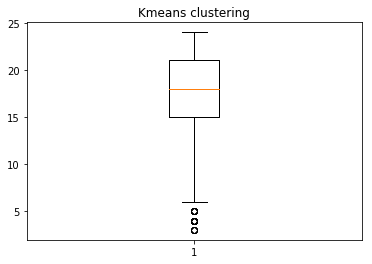

In [34]:
display(unique_kmeans)
fig2, ax2 = plt.subplots()
ax2.set_title('Kmeans clustering')
ax2.boxplot(unique_kmeans['Cluster Num'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb6fa986278>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb75c0fb278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6fa986e10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb75c0fbd68>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb75c0fb978>],
 'means': []}

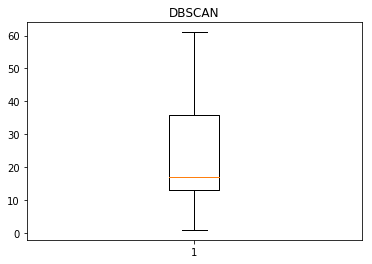

In [35]:
#display(unique_dbscan)
fig3, ax3 = plt.subplots()
ax3.set_title('DBSCAN')
ax3.boxplot(unique_dbscan['Cluster Num'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb75c092ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb75c199358>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb75c092fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb75c1199b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb75c1192b0>],
 'means': []}

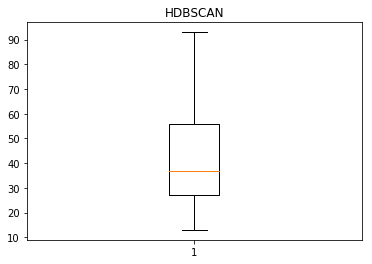

In [36]:
#display(unique_hdbscan)
fig4, ax4 = plt.subplots()
ax4.set_title('HDBSCAN')
ax4.boxplot(unique_hdbscan['Cluster Num'])

#  Look into the soma intra-cluster and inter-cluster distance
* **uniqueDF** is the dataframe with unrepeated parameters
* **cluster_method** can be 'Hierarchy','Kmeans', 'DBSCAN','HDBSCAN','' 
* **swcDF** is the dataframe containing the coordinate of the soma
* **metric** can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'
* **kvalue** can be string'all', it can also be a certain number. In that case, the inter-cluster distance will only count the k-nearest other-cluster soma.

In [234]:
import ast

import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
def soma_Distance(uniqueDF,cluster_method,swcDF,metric,kvalue):
    somaDF = swcDF.copy()
    df_pre = uniqueDF.copy()
    df_pre = df_pre[df_pre['Silhouette Coefficient']!='below'].copy()
    df_pre = df_pre[df_pre['Silhouette Coefficient']!='above'].copy()
    df_pre = df_pre[df_pre['Completeness']!=1].copy()
    colname = ['V','ARI','AMI','SC','parameter','Cluster Num','label list','AVG_intra','AVG_inter']
    index_ls = df_pre.index


    df = pd.DataFrame(columns = colname,index = index_ls)
    df['parameter'] = df_pre.loc[index_ls,'parameter']

    #under each parameter
    for iter_idx in df.index:
        _ = ns. get_clusters(method = cluster_method,karg_dict = ast.literal_eval(df.loc[iter_idx]['parameter']))
        somaDF['cluster'] = ns.metadata['Cluster']
        if cluster_method == 'HDBSCAN':
            somaDF = somaDF[somaDF['cluster']>0].copy()
        V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
        typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
        detailDF = pd.DataFrame(index = typeR,columns = ['Cluster Type','INTRAlist','INTERlist','AVG_intra','AVG_inter'])
        detailDF.loc[:,'Cluster Type'] = detailDF.index
        if len(typeR)<2:
            SS = 'below'
        elif len(typeR)>=ns.UMAP.shape[0]:
            SS = 'above'
        else:
            SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
            #LABEL LIST CAN BE DETELETED LATER
        df.loc[iter_idx,'label list'] = ' '.join([str(i) for i in typeR])  

        #UNDER EACH PARAMETER
        # for each cluster result
        for label_idx in typeR:
            intra_list = []
            inter_list = []

            swc_intra = somaDF[somaDF['cluster'] ==label_idx].iloc[:,:-1].copy()#DF
            swc_inter = somaDF[somaDF['cluster'] !=label_idx].iloc[:,:-1].copy()#DF
            value_intra = swc_intra.values
            value_inter = swc_inter.values

            for i in range(value_intra.shape[0]):
                #exchange the specific row, make it to be the first row
                cal_intra=value_intra
                if i != 0:
                    cal_intra[[0,i],:] = cal_intra[[i,0],:]
                temp_intra = pdist(cal_intra, metric).reshape((len(pdist(cal_intra, metric)),1))
                # for each sample in that cluster, record the avg intra cluster distance
                intra_list.append(np.sum(temp_intra[:(value_intra.shape[0]-1),:])/(value_intra.shape[0]-1))
            # If a certai cluster only has 1 element, then the intra distance is 'nan'
            detailDF.loc[label_idx,'INTRAlist'] = intra_list#' '.join([str(i) for i in intra_list])    
            detailDF.loc[label_idx,'AVG_intra'] = np.mean(np.array(detailDF.loc[label_idx,'INTRAlist']))
            if kvalue == 'all':
                #sum inter will be a column vector, each element stores the corresponding distance
                sum_inter = np.zeros((value_inter.shape[0],1))
                # for each sample in that cluster
                for i in range(value_intra.shape[0]):
                    cal_inter = np.row_stack((value_intra[i,:],value_inter))
                    temp_inter = pdist(cal_inter, metric).reshape((len(pdist(cal_inter, metric)),1))[:(value_inter.shape[0]),:]
                    #assert(sum_inter.shape == temp_inter.shape,"Inter cluster record does not equal to number of out-cluster samples")
                    sum_iter = sum_inter + temp_inter
                # for each sample in that cluster, record the avg intra cluster distance    
                sum_iter = sum_iter/value_intra.shape[0]
                #row list
                inter_list = sum_iter.tolist()           
            detailDF.loc[label_idx,'INTERlist'] = inter_list   
            #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
            detailDF.loc[label_idx,'AVG_inter'] = np.mean(np.array(detailDF.loc[label_idx,'INTERlist']))
            detailDF[detailDF .isnull()]=0

        df.loc[iter_idx,'AVG_intra'] = (detailDF['AVG_intra']).sum()/detailDF.shape[0]
        df.loc[iter_idx,'AVG_inter'] = (detailDF['AVG_inter']).sum()/detailDF.shape[0]
        df.loc[iter_idx,'V'] = V
        df.loc[iter_idx,'ARI'] = ARI
        df.loc[iter_idx,'AMI'] = AMI
        df.loc[iter_idx,'SC'] = SS
        typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
        #print(hdbscan_dict)
        df.loc[iter_idx,'Cluster Num'] = len(typeR)          
    return df

In [235]:
soma_hier = soma_Distance(unique_hier,'Hierarchy',ns.features['soma_features'].raw_data.copy(),'euclidean','all')


Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method centroid requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering




*************Note:**************
Method median requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



Result of Hierarchy CLustering




*************Note:**************
Method ward requires the distance metric to be Euclidean


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
soma_kmeans = soma_Distance(unique_kmeans,'Kmeans',ns.features['soma_features'].raw_data.copy(),'euclidean','all')


Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Kmeans


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [ ]:
soma_dbscan= soma_Distance(unique_dbscan,'DBSCAN',ns.features['soma_features'].raw_data.copy(),'euclidean','all')


In [ ]:
soma_hdbscan = soma_Distance(unique_hdbscan,'HDBSCAN',ns.features['soma_features'].raw_data.copy(),'euclidean','all')

In [227]:
uniqueDF=unique_hier.copy()
cluster_method ='Hierarchy'




swcDF=ns.features['soma_features'].raw_data.copy()
metric = 'canberra'
kvalue = 'all'
somaDF = swcDF.copy()
df_pre = uniqueDF.copy()
df_pre = df_pre[df_pre['Silhouette Coefficient']!='below'].copy()
df_pre = df_pre[df_pre['Silhouette Coefficient']!='above'].copy()
df_pre = df_pre[df_pre['Completeness']!=1].copy()
colname = ['V','ARI','AMI','SC','parameter','Cluster Num','label list','AVG_intra','AVG_inter']
index_ls = df_pre.index


df = pd.DataFrame(columns = colname,index = index_ls)
df['parameter'] = df_pre.loc[index_ls,'parameter']

#under each parameter
for iter_idx in df.index:
    
    _ = ns. get_clusters(method = cluster_method,karg_dict = ast.literal_eval(df.loc[iter_idx]['parameter']))
    somaDF['cluster'] = ns.metadata['Cluster']
    V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
    ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
    AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    detailDF = pd.DataFrame(index = typeR,columns = ['Cluster Type','INTRAlist','INTERlist','AVG_intra','AVG_inter'])
    detailDF.loc[:,'Cluster Type'] = detailDF.index
    if len(typeR)<2:
        SS = 'below'
    elif len(typeR)>=ns.UMAP.shape[0]:
        SS = 'above'
    else:
        SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
        #LABEL LIST CAN BE DETELETED LATER
    df.loc[iter_idx,'label list'] = ' '.join([str(i) for i in typeR])  
    
    #UNDER EACH PARAMETER
    # for each cluster result
    for label_idx in typeR:
        intra_list = []
        inter_list = []
        
        swc_intra = somaDF[somaDF['cluster'] ==label_idx].iloc[:,:-1].copy()#DF
        swc_inter = somaDF[somaDF['cluster'] !=label_idx].iloc[:,:-1].copy()#DF
        value_intra = swc_intra.values
        value_inter = swc_inter.values
        
        for i in range(value_intra.shape[0]):
            #exchange the specific row, make it to be the first row
            cal_intra=value_intra
            if i != 0:
                cal_intra[[0,i],:] = cal_intra[[i,0],:]
            temp_intra = pdist(cal_intra, metric).reshape((len(pdist(cal_intra, metric)),1))
            # for each sample in that cluster, record the avg intra cluster distance
            intra_list.append(np.sum(temp_intra[:(value_intra.shape[0]-1),:])/(value_intra.shape[0]-1))
        # If a certai cluster only has 1 element, then the intra distance is 'nan'
        detailDF.loc[label_idx,'INTRAlist'] = intra_list#' '.join([str(i) for i in intra_list])    
        detailDF.loc[label_idx,'AVG_intra'] = np.mean(np.array(detailDF.loc[label_idx,'INTRAlist']))
        if kvalue == 'all':
            #sum inter will be a column vector, each element stores the corresponding distance
            sum_inter = np.zeros((value_inter.shape[0],1))
            # for each sample in that cluster
            for i in range(value_intra.shape[0]):
                cal_inter = np.row_stack((value_intra[i,:],value_inter))
                temp_inter = pdist(cal_inter, metric).reshape((len(pdist(cal_inter, metric)),1))[:(value_inter.shape[0]),:]
                assert(sum_inter.shape == temp_inter.shape,"Inter cluster record does not equal to number of out-cluster samples")
                sum_iter = sum_inter + temp_inter
            # for each sample in that cluster, record the avg intra cluster distance    
            sum_iter = sum_iter/value_intra.shape[0]
            #row list
            inter_list = sum_iter.tolist()           
        detailDF.loc[label_idx,'INTERlist'] = inter_list   
        assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
        detailDF.loc[label_idx,'AVG_inter'] = np.mean(np.array(detailDF.loc[label_idx,'INTERlist']))
        detailDF[detailDF .isnull()]=0
    
    df.loc[iter_idx,'AVG_intra'] = (detailDF['AVG_intra']).sum()/detailDF.shape[0]
    df.loc[iter_idx,'AVG_inter'] = (detailDF['AVG_inter']).sum()/detailDF.shape[0]
    df.loc[iter_idx,'V-measure'] = V
    df.loc[iter_idx,'Adjusted Rand Index'] = ARI
    df.loc[iter_idx,'Adjusted Mutual Information'] = AMI
    df.loc[iter_idx,'Silhouette Coefficient'] = SS
    typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
    #print(hdbscan_dict)
    df.loc[iter_idx,'Cluster Num'] = len(typeR)
    ddd

<>:71: SyntaxWarning:

assertion is always true, perhaps remove parentheses?

<>:71: SyntaxWarning:

assertion is always true, perhaps remove parentheses?

<>:71: SyntaxWarning:

assertion is always true, perhaps remove parentheses?

<ipython-input-227-c53ad0f9c1dc>:71: SyntaxWarning:

assertion is always true, perhaps remove parentheses?

/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning:

invalid value encountered in double_scalars



NameError: name 'ddd' is not defined

In [228]:
df

,V,ARI,AMI,SC,parameter,Cluster Num,label list,AVG_intra,AVG_inter,V-measure,Adjusted Rand Index,Adjusted Mutual Information,Silhouette Coefficient
idx,,,,,,,,,,,,,
Hier0,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",337,C1 C10 C100 C101 C102 C103 C104 C105 C106 C107 C108 C109 C11 C110 C111 C112 C113 C114 C115 C116 C117 C118 C119 C12 C120 C121 C122 C123 C124 C125 C126 C127 C128 C129 C13 C130 C131 C132 C133 C134 C135 C136 C137 C138 C139 C14 C140 C141 C142 C143 C144 C145 C146 C147 C148 C149 C15 C150 C151 C152 C153...,0.1343,0.337906,0.596129,0.03821,0.150883,0.451937
Hier1,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier2,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier3,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'inconsistent', 'depth': 5, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier26,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier52,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'braycurtis', 'criterionH': 'maxclust_monocrit', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier65,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 2, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier66,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 3, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hier67,NaN,NaN,NaN,NaN,"{'L_method': 'single', 'L_metric': 'canberra', 'criterionH': 'inconsistent', 'depth': 4, 'R': None, 't': 0.9, 'optimal_ordering': False}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
detailDF.sum(level='AVG_intra')

ValueError: level name AVG_intra is not the name of the index

In [226]:
(detailDF['AVG_intra']).sum()

45.25898322928179

In [222]:
(detailDF)

,Cluster Type,INTRAlist,INTERlist,AVG_intra,AVG_inter
C1,C1,"[0.19589932221693404, 0.0747135470918236, 0.07096295052341274, 0.07214981232032379, 0.10364203929697273, 0.07739671130689334, 0.0763023052672767, 0.07513657649588915, 0.15013830855881521, 0.09396767791532797, 0.08544817125847835, 0.09351211567376765, 0.21943544941378032]","[[0.061067082581723234], [0.06346722787925553], [0.07095573022055862], [0.06230579228761246], [0.056281091949009494], [0.07308996210831185], [0.0733031869865106], [0.07364388338441946], [0.07426256813228253], [0.06395508783713398], [0.0495611911516507], [0.03909758672625849], [0.0580425542858591...",0.106823,0.0377172
C10,C10,"[0.12271832803949088, 0.16111145320144682, 0.16029667481819757, 0.11057724947682038, 0.11014139972438068, 0.13727563928900463, 0.11889917197820525, 0.20062116194875323, 0.2870691150619975]","[[0.10513006718834049], [0.07272288244522722], [0.08289892190110465], [0.09209320825240432], [0.0883515390103306], [0.11330677394361022], [0.09500986646973818], [0.08728060515607582], [0.08810560530124749], [0.08799144955847223], [0.07945662164709938], [0.08355830093246197], [0.06743177002268269...",0.156523,0.0645279
C100,C100,"[0.40447773564726996, 0.549543492888662, 0.5260011945468896]","[[0.20858187508559944], [0.13270708079487203], [0.09079707901519518], [0.1685366840835895], [0.1543278168771354], [0.2399779933553082], [0.18249095285130504], [0.17111085094532574], [0.08386773178894374], [0.1568944548182547], [0.21675598177309716], [0.23562572288106365], [0.18849318141116167], ...",0.493341,0.243804
C101,C101,[nan],"[[0.6195112363004719], [0.6256055326501109], [0.7148272362644575], [0.6247013456556476], [0.5385598989842703], [0.7828765727460479], [0.7757394782337997], [0.7777538271265061], [0.7546528819354639], [0.6384144209974425], [0.7824912897099691], [0.6750646106937602], [0.9020945628363801], [0.900387...",NaN,0.540398
C102,C102,"[0.43572720936680864, 0.5181370683721005, 0.18268003152315135, 0.18121791138025037, 0.18587827204723686, 0.18655495630299807, 0.18871850241090424, 0.25386101235551567]","[[0.07183593125293875], [0.07280815518671765], [0.08417258940014723], [0.0725491499709365], [0.061723134001224124], [0.09237308155018817], [0.09158158799332468], [0.09190296869315095], [0.08926157936466776], [0.07431812034449103], [0.09483655355006076], [0.08126497983549051], [0.1099855848796088...",0.266597,0.0671631
C103,C103,[nan],"[[0.6499736388076952], [0.6441146141188346], [0.7264381613008529], [0.6503740657602024], [0.5644339483300973], [0.8122310185108084], [0.7994720847965814], [0.7991566063406133], [0.7629283255951095], [0.6616311572347728], [0.9197754057309165], [0.8157971689507162], [1.0325212212563584], [1.031717...",NaN,0.634324
C104,C104,"[0.5497666741734495, 0.4449793939387357, 0.2024238615506737, 0.23374949562734293, 0.21728787930832563, 0.17976701327364653, 0.17528847786907673, 0.17439740428972186, 0.18201910642025163, 0.18399861223531247, 0.18580336925861216, 0.18250900363363196, 0.19302701049984214]","[[0.040958962786664256], [0.04155214681243666], [0.04860075378515319], [0.0413647374247966], [0.034613524187374324], [0.053549371606363194], [0.053186010222707525], [0.05346037191122209], [0.05178325392521953], [0.042344447824075454], [0.06134734100944246], [0.05297113388112136], [0.070714492485...",0.238847,0.0433078
C105,C105,"[0.09994502682575575, 0.11262880022425771, 0.06394755979701744, 0.05873453803484946]","[[0.13679053049429263], [0.13773940673610013], [0.1599697313940391], [0.13786904847467674], [0.11633107346289866], [0.17841600668925675], [0.1758697004750176], [0.17613903555103638], [0.16983615318467435], [0.14167518152754555], [0.18972810234033666], [0.16250893034444558], [0.2196042816688051],...",0.083814,0.142069
C106,C106,"[0.07558316652698918, 0.0461306029825527, 0.049801006026984285]","[[0.17429667922741365], [0.17585304295023016], [0.20573047068775355], [0.1758623868553536], [0.14718395787517913], [0.23014223288594607], [0.22663424986450317], [0.2269773

In [204]:
detailDF

,Cluster Type,INTRAlist,INTERlist,AVG_intra,AVG_inter
C1,C1,0.19589932221693404 0.0747135470918236 0.07096295052341274 0.07214981232032379 0.10364203929697273 0.07739671130689334 0.0763023052672767 0.07513657649588915 0.15013830855881521 0.09396767791532797 0.08544817125847835 0.09351211567376765 0.21943544941378032,"[[0.061067082581723234], [0.06346722787925553], [0.07095573022055862], [0.06230579228761246], [0.056281091949009494], [0.07308996210831185], [0.0733031869865106], [0.07364388338441946], [0.07426256813228253], [0.06395508783713398], [0.0495611911516507], [0.03909758672625849], [0.0580425542858591...",NaN,0.0377172
C10,C10,0.12271832803949088 0.16111145320144682 0.16029667481819757 0.11057724947682038 0.11014139972438068 0.13727563928900463 0.11889917197820525 0.20062116194875323 0.2870691150619975,"[[0.10513006718834049], [0.07272288244522722], [0.08289892190110465], [0.09209320825240432], [0.0883515390103306], [0.11330677394361022], [0.09500986646973818], [0.08728060515607582], [0.08810560530124749], [0.08799144955847223], [0.07945662164709938], [0.08355830093246197], [0.06743177002268269...",NaN,0.0645279
C100,C100,0.40447773564726996 0.549543492888662 0.5260011945468896,"[[0.20858187508559944], [0.13270708079487203], [0.09079707901519518], [0.1685366840835895], [0.1543278168771354], [0.2399779933553082], [0.18249095285130504], [0.17111085094532574], [0.08386773178894374], [0.1568944548182547], [0.21675598177309716], [0.23562572288106365], [0.18849318141116167], ...",NaN,0.243804
C101,C101,nan,"[[0.6195112363004719], [0.6256055326501109], [0.7148272362644575], [0.6247013456556476], [0.5385598989842703], [0.7828765727460479], [0.7757394782337997], [0.7777538271265061], [0.7546528819354639], [0.6384144209974425], [0.7824912897099691], [0.6750646106937602], [0.9020945628363801], [0.900387...",NaN,0.540398
C102,C102,0.43572720936680864 0.5181370683721005 0.18268003152315135 0.18121791138025037 0.18587827204723686 0.18655495630299807 0.18871850241090424 0.25386101235551567,"[[0.07183593125293875], [0.07280815518671765], [0.08417258940014723], [0.0725491499709365], [0.061723134001224124], [0.09237308155018817], [0.09158158799332468], [0.09190296869315095], [0.08926157936466776], [0.07431812034449103], [0.09483655355006076], [0.08126497983549051], [0.1099855848796088...",NaN,0.0671631
C103,C103,nan,"[[0.6499736388076952], [0.6441146141188346], [0.7264381613008529], [0.6503740657602024], [0.5644339483300973], [0.8122310185108084], [0.7994720847965814], [0.7991566063406133], [0.7629283255951095], [0.6616311572347728], [0.9197754057309165], [0.8157971689507162], [1.0325212212563584], [1.031717...",NaN,0.634324
C104,C104,0.5497666741734495 0.4449793939387357 0.2024238615506737 0.23374949562734293 0.21728787930832563 0.17976701327364653 0.17528847786907673 0.17439740428972186 0.18201910642025163 0.18399861223531247 0.18580336925861216 0.18250900363363196 0.19302701049984214,"[[0.040958962786664256], [0.04155214681243666], [0.04860075378515319], [0.0413647374247966], [0.034613524187374324], [0.053549371606363194], [0.053186010222707525], [0.05346037191122209], [0.05178325392521953], [0.042344447824075454], [0.06134734100944246], [0.05297113388112136], [0.070714492485...",NaN,0.0433078
C105,C105,0.09994502682575575 0.11262880022425771 0.06394755979701744 0.05873453803484946,"[[0.13679053049429263], [0.13773940673610013], [0.1599697313940391], [0.13786904847467674], [0.11633107346289866], [0.17841600668925675], [0.1758697004750176], [0.17613903555103638], [0.16983615318467435], [0.14167518152754555], [0.18972810234033666], [0.16250893034444558], [0.2196042816688051],...",NaN,0.142069
C106,C106,0.07558316652698918 0.0461306029825527 0.049801006026984285,"[[0.17429667922741365], [0.17585304295023016], [0.20573047068775355], [0.1758623868553536], [0.14718395787517913], [0.23014223288594607], [0.22663424986450317], [0.22697736515563585], [0.21897688040972688], [0.1812275668366503], [0.24216862017933408], [0.20561645759296032], [0.2

In [198]:
np.mean(np.array(detailDF.loc['C1','INTERlist']))

0.000503412781725117

In [116]:
_ = ns. get_clusters(method = cluster_method,karg_dict = ast.literal_eval(df.loc[iter_idx]['parameter']))
somaDF['cluster'] = ns.metadata['Cluster']
V = metrics.v_measure_score(ns.metadata['CellType'],ns.metadata['Cluster'])
ARI = metrics.adjusted_rand_score(ns.metadata['CellType'],ns.metadata['Cluster'])
AMI = metrics.adjusted_mutual_info_score(ns.metadata['CellType'],ns.metadata['Cluster'])
typeR, typeC = np.unique(ns.metadata['Cluster'], return_counts = True)
detailDF = pd.DataFrame(index = typeR,columns = ['Cluster Type','INTRAlist','INTERlist','AVG_intra','AVG_inter'])
if len(typeR)<2:
    SS = 'below'
elif len(typeR)>=ns.UMAP.shape[0]:
    SS = 'above'
else:
    SS = metrics.silhouette_score(ns.UMAP, ns.metadata['Cluster'], metric='sqeuclidean')
    #LABEL LIST CAN BE DETELETED LATER
df.loc[iter_idx,'label list'] = ' '.join([str(i) for i in typeR])  

#UNDER EACH PARAMETER
intra_list = []
inter_list = []
# for each cluster
for label_idx in typeR:
    swc_intra = somaDF[somaDF['cluster'] ==label_idx].iloc[:,:-1].copy()#DF
    swc_inter = somaDF[somaDF['cluster'] !=label_idx].iloc[:,:-1].copy()#DF
    value_intra = swc_intra.values
    value_iter = swc_inter.values
    for i in range(value_intra.shape[0]):
        #exchange the specific row, make it to be the first row
        cal_intra=value_intra
        if i != 0:
            cal_intra[[0,i],:] = cal_intra[[i,0],:]
        temp_intra = pdist(cal_intra, metric).reshape((len(pdist(cal_intra, metric)),1))
        intra_list.append(sum(temp_intra[:(value_intra.shape[0]-1)])/(value_intra.shape[0]-1))
    detailDF.loc[label_idx,'INTRAlist'] = ' '.join([str(i) for i in intra_list])    
    if kvalue == 'all':
        sum = 0
        # for each row in that cluster
        for i in range(value_intra.shape[0]):
            cal_iter = np.row_stack((swc_intra.values[i,:],intervalue))
            temp_inter = pdist(cal_inter, metric).reshape((len(pdist(cal_value, metric)),1))
            sum = sum + temp[]
        inter_list.append(sum(temp_inter[:(value_inter.shape[0])])/(value_intra.shape[0]))    
    detailDF.loc[label_idx,'INTERlist'] = ' '.join([str(i) for i in inter_list])

SyntaxError: invalid syntax (<ipython-input-116-2aead10a269b>, line 40)

In [95]:
intervalue = swc_inter.values
cal_value = np.row_stack((swc_intra.values[0,:],intervalue))
cal_value.shape

(985, 3)

In [96]:
For pdist, the first K value is the distance

2955

In [110]:
np.array([[1,2,3],[1,2,3],[1,2,5],[1,2,4]]).shape

(4, 3)

In [108]:
a=pdist([[1,2,3],[1,2,3],[1,2,5],[1,2,4]],'euclidean')
a.reshape((len(a),1))

array([[0.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.]])

In [111]:
a[0:4]

array([0., 2., 1., 2.])

In [105]:
np.sqrt(1+4)

2.23606797749979

In [86]:
soma_intraD(unique_hier,'Hierarchy',ns.features['soma_features'].raw_data,'canberra','all')

Result of Hierarchy CLustering


/home/penglab/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



TypeError: 'numpy.ndarray' object is not callable

In [ ]:
#  ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’

In [53]:
ns.features['soma_features'].raw_data
from sklearn.metrics import pairwise_distances
pairwise_distances(X[y == i], X[y == j],
                                                metric=metric)

,x,y,z
AA0001,4625.38,2534.790,2977.33
AA0002,5066.66,1824.090,3679.87
AA0003,4844.88,1513.880,3771.45
AA0004,4688.96,2212.970,3325.67
AA0005,4481.65,2314.060,3973.65
AA0006,3568.90,2335.160,2961.92
AA0007,4406.29,1968.240,2886.26
AA0008,4892.07,1824.550,2772.00
AA0009,4941.39,1385.280,3667.47
AA0010,3851.89,2086.760,4136.42


In [75]:
from scipy.spatial.distance import pdist, squareform
mm = np.array([[1, 2,3], [3, 4,5],[5,6,7]])
aa = np.row_stack((mm,[7,7,7]))
aa.shape[0]
a=[1, 2,3]

In [77]:
len(a)

3

In [ ]:
result_hier_self = result_hier.copy()
result_kmeans_self = result_kmeans.copy()
result_dbscan_self = result_dbscan.copy()
result_hdbscan_self = result_hdbscan.copy()

result_hier_self = result_hier_self.iloc[:,:-1].drop_duplicates()
result_kmeans_self = result_kmeans_self.iloc[:,:-1].drop_duplicates()
result_dbscan_self = result_dbscan_self.iloc[:,:-1].drop_duplicates()
result_hdbscan_self = result_hdbscan_self.iloc[:,:-1].drop_duplicates()



### Another way to drop the duplicated rows

In [ ]:
result_hier_self = result_hier_self.iloc[:,:-1].drop_duplicates()
result_kmeans_self = result_kmeans_self.iloc[:,:-1].drop_duplicates()
result_dbscan_self = result_dbscan_self.iloc[:,:-1].drop_duplicates()
result_hdbscan_self = result_hdbscan_self.iloc[:,:-1].drop_duplicates()
idx_hier = result_hier_self.index
idx_kmeans = result_kmeans_self.index
idx_dbscan = result_dbscan_self.index
idx_hdbscan = result_hdbscan_self.index



### PLot the statistic characters the duplicated rows